# Data Visualisation and Exploration

### Imports

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
OUTCOMES = [
'ATP in VT/VF delivered',
'ATP One Shot delivered',
'VT1 therapy episodes',
'VF episodes',
'ATP in VT zones started',
'ATP One Shot started',
'ATP in VT zones successful',
'ATP One Shot successful',
'Shocks started',
'Shocks aborted',
'Shocks successful']

In [3]:
VENTR_FEATURES = ['RV pacing impedance [ohm]',
 'RV sensing amplitude (daily mean) [mV]',
 'RV sensing amplitude (daily min.) [mV]',
 'Daily shock lead impedance [ohm]',
 'Right ven. pacing (RVp) [%]',
 'VT1 monitoring episodes',
 'VT1 therapy episodes',
 'VT2 episodes',
 'VF episodes',
 'Episodes during temporary program',
 'ATP in VT zones started',
 'ATP in VT zones successful',
 'ATP One Shot started',
 'ATP One Shot successful',
 'Shocks started',
 'Shocks aborted',
 'Shocks successful',
 'Ineffective ven. max. energy shocks',
 'Mean ventricular heart rate [bpm]',
 'Mean ventricular heart rate at rest [bpm]',
 'Patient activity [% of day]',
 'ATP in VT/VF delivered',
 'ATP One Shot delivered']

### Importing the data

In [4]:
outcome_df = pd.read_csv('/Users/ijakaityte/Documents/Health Data Sc/Project/icd_data/outcome_df_plotting2.csv')

### Functions

In [5]:
def split_plot(df, window_size=60):
    '''
    Split time series data for cases and controls leading up to shock events.

    This function takes a time series DataFrame, splits the data for each patient
    into two segments:
    the period leading up to shock events for cases, and all data for controls.
    The segment for cases starts `window_size` time points before the shock event.

    Parameters:
    -----------
    df - DataFrame
        The DataFrame with time series data.
    window_size - int, optional
        The number of time points before a shock event to include for cases.
    '''
    new_df = pd.DataFrame()
    pt_id = df['patient_id'].unique()
    
    # Iterating through patients' data.
    for n in pt_id:
        pt_data = df[df['patient_id'] == n]
        is_case = pt_data['case'].iloc[0] == 1
        if is_case:
            for i, row in pt_data.iterrows():
                # Looking for a row with a shock that happened predetermined 
                # time ago. 
                if row['shock'] > 0 and row['index'] >= window_size:
                    # Including all the rows with lower value than the shock index.
                    pt_data = pt_data[pt_data['index']>=row['index']]
                    new_df = pd.concat([new_df, pt_data])
                    break
        else:
            new_df = pd.concat([new_df, pt_data])
    return new_df

In [6]:
def format_time_ser_df(df, variable):
    '''
    Formats a time series DataFrame for analysis.

    This function takes a DataFrame with time series data, extracts a specific variable,
    and pivots it to create a new DataFrame suitable for further analysis. It removes rows
    with missing values for the selected variable.

    Parameters: 
    -----------
    df - pd.DataFrame
        the dataframe with timeseries data of all patients in one column.
    variable - str
        the name of the column we are interested in analysing
    '''
    df_var = df[[variable, 'patient_id', 'index']].copy()
    new_df = df_var.pivot(index='patient_id', columns='index', values=variable)
    to_drop = new_df[new_df.isna().all(axis=1)].index
    new_df = new_df.drop(to_drop, axis=0)
    return new_df

In [ ]:
def gen_ax(outcome_df, variable, pt_id):
    '''
    Generates a time series plot with rolling averages for a specified variable.

    This function takes an outcome DataFrame, extracts a specific variable for a given
    patient ID, and generates a time series plot along with two rolling averages
    (7-day and 30-day). The plot visualizes the observed values and their smoothed trends.

    Parameters:
    ----------
    outcome_df - DataFrame
        The DataFrame containing outcome data.
    variable - str
        The variable to be plotted.
    pt_id - str
        The patient ID used to extract the data.

    Returns:
    -------
    tuple
        A tuple containing the matplotlib axis object and the patient's data series.
    '''
    # Only taking into account data leading up to ICD therapy in the cases
    df = split_plot(outcome_df)
    # Reformatting data for plotting.
    new_df = format_time_ser_df(df, variable=variable)
    new_smth = new_df.T.reset_index().copy()

    # Selecting data of a specific patient
    pt_data = new_smth[[pt_id]].dropna().reset_index(drop=True).copy()

    # Creating two new data frames holding the rolling averages.
    # Plots the mean of the last 7 days.
    paeds_w_trend = pt_data.rolling(window=7, center=True).mean()
    # Plots the mean of the last 30 days.
    paeds_m_trend = pt_data.rolling(window=30, center=True).mean()

    # Plotting the time series
    ax = pt_data.plot(figsize=(12, 4), linestyle='-.', linewidth=2, label='observed')
    paeds_w_trend.plot(ax=ax, label="smoothed_7_days", linewidth=2.5)
    paeds_m_trend.plot(ax=ax, label="smoothed_30_days", linewidth=3)
    ax.legend(['True Values', '7 Day Rolling Average', '30 Day Rolling Average'],
            loc=2)
            
    return ax, pt_data

In [8]:
def explore_table(table_df, feature_list):
    '''
    Explore descriptive statistics of features for cases and controls.

    This function generates a summary of descriptive statistics for selected features
    in a provided DataFrame, categorised by cases and controls. The function calculates
    statistics like mean, standard deviation, and median (50th percentile) for each feature.

    Parameters:
    -----------
    table_df - DataFrame
        The DataFrame containing feature data and case labels - can have any
        number of features.
    feature_list - list
        List of features to explore.

    Returns:
    --------
    DataFrame
        A DataFrame containing descriptive statistics for the selected features,
        categorized by cases and controls.
    '''
    # The statistics to collect.
    cols = ['mean', 'std', '50%']
    # Creating a multindex dataframe to store results. 
    exp_df = pd.DataFrame(index=pd.MultiIndex.from_product([feature_list, cols]))
    # Empty array for column creation.
    len_col = len(exp_df)
    col = np.zeros(len_col)
    exp_df['cases'] = col
    exp_df['controls'] = col

    # Getting summary statistics of cases and controls with .describe()
    cases = table_df[table_df['case']==1].describe().copy()
    controls = table_df[table_df['case']==0].describe().copy()

    cases = cases.T.reset_index().copy()
    controls = controls.T.reset_index().copy()

    # Adding the relevant statistics to the dataframe.
    for i in feature_list:
        for c in cols:
            exp_df.loc[(i, c), 'cases'] = cases[cases['index']==i][c].values

    for i in feature_list:
        for c in cols:
            exp_df.loc[(i, c), 'controls'] = controls[controls['index']==i][c].values

    return exp_df

### Outcomes Plot

In [9]:
# Replacing NaN values with 0.
plt_out = outcome_df[OUTCOMES].copy()
plt_out = plt_out.replace(0, np.nan)

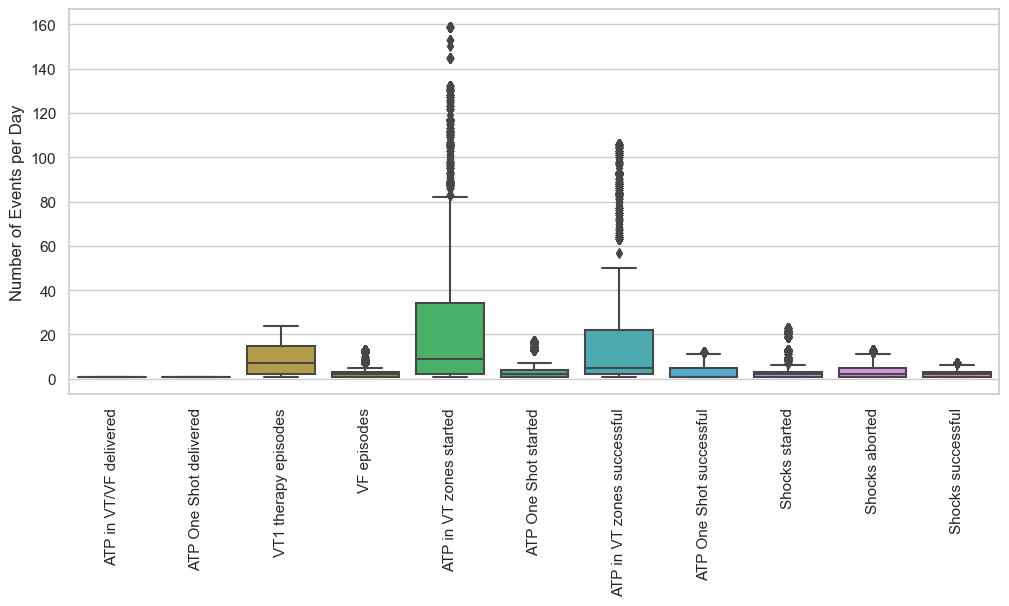

In [10]:
sns.set(style="whitegrid", palette="Spectral")
# Plotting different outcomes as box plots to compare. 
fig, ax = plt.subplots(figsize=(12, 5))
melt_dt = pd.melt(plt_out[OUTCOMES], value_vars=OUTCOMES)
sns.boxplot(x="variable", y="value", data=melt_dt, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of Events per Day');
plt.xticks(rotation=90);

### Plotting parameters over time in a case and control

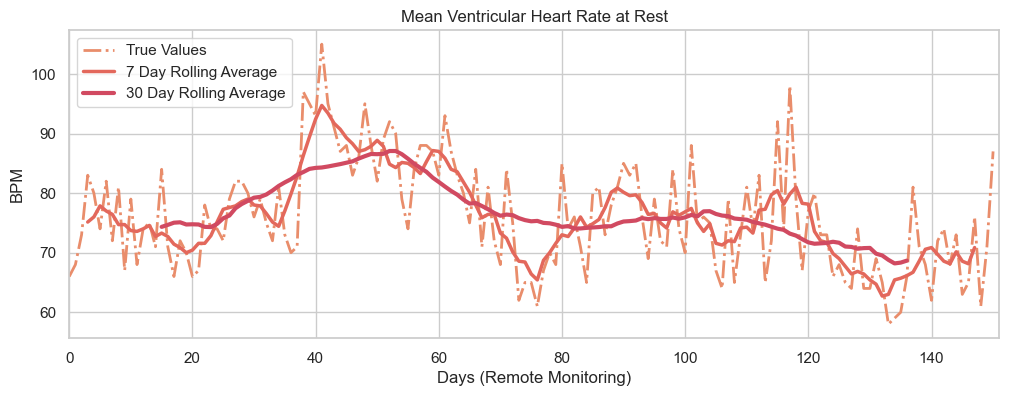

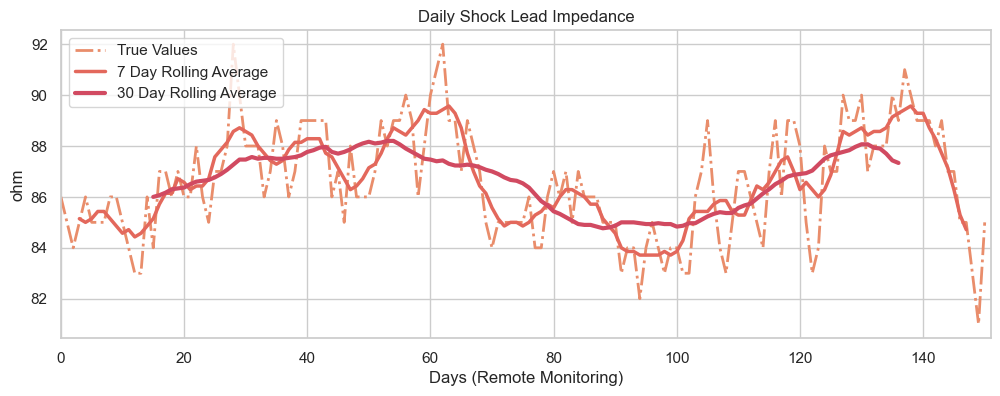

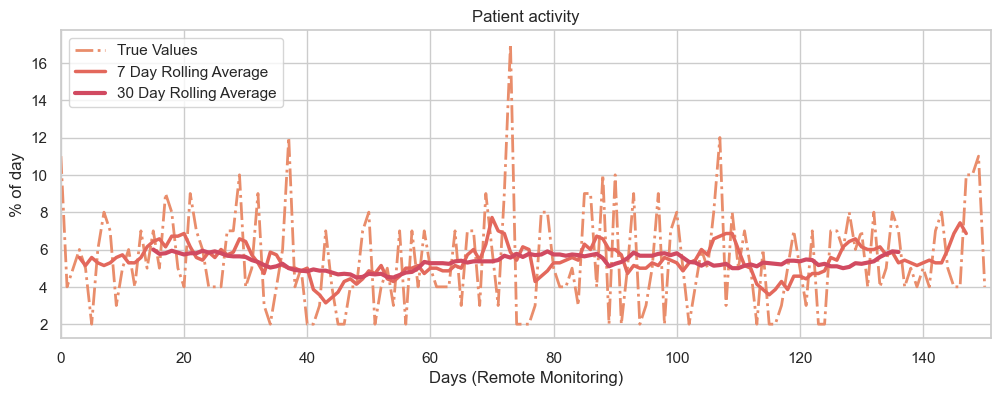

In [13]:
# Case
pt_id = 156
sns.set(style="whitegrid", palette="flare")


variable='Mean ventricular heart rate at rest [bpm]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)

ax.set_title("Mean Ventricular Heart Rate at Rest")
ax.set_ylabel("BPM")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data))


variable='Daily shock lead impedance [ohm]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)
ax.set_title("Daily Shock Lead Impedance")
ax.set_ylabel("ohm")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data))


variable='Patient activity [% of day]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)
ax.set_title('Patient activity')
ax.set_ylabel("% of day")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data));

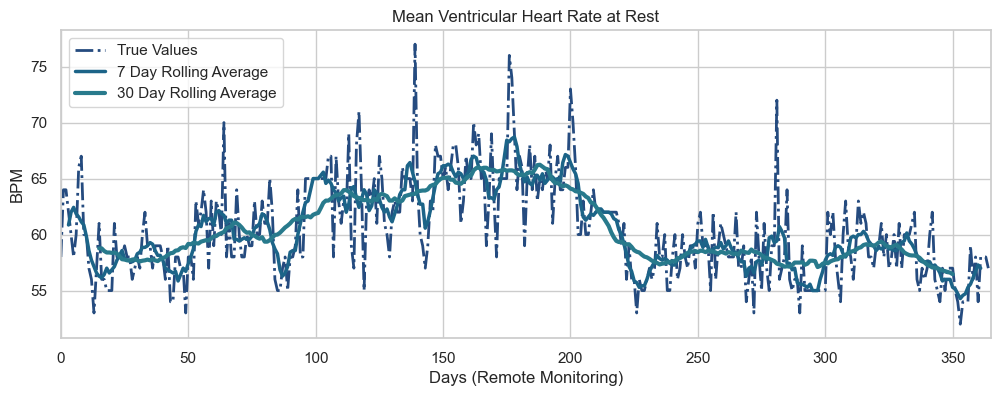

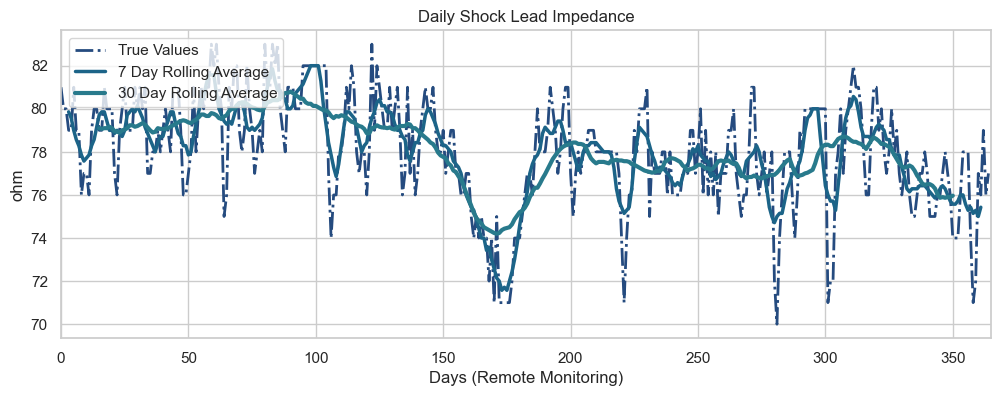

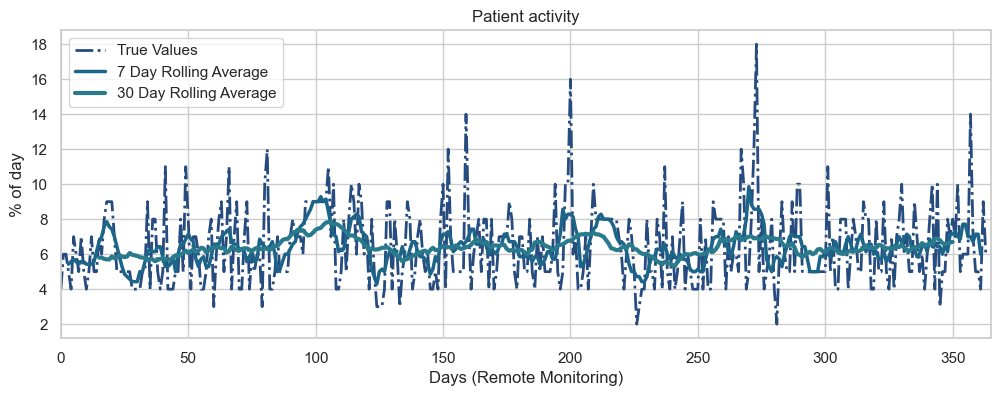

In [14]:
# Control
pt_id = 197
sns.set(style="whitegrid", palette="crest_r")


variable='Mean ventricular heart rate at rest [bpm]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)

ax.set_title("Mean Ventricular Heart Rate at Rest")
ax.set_ylabel("BPM")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data))


variable='Daily shock lead impedance [ohm]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)
ax.set_title("Daily Shock Lead Impedance")
ax.set_ylabel("ohm")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data))


variable='Patient activity [% of day]'
ax, pt_data = gen_ax(outcome_df, variable, pt_id)
ax.set_title('Patient activity')
ax.set_ylabel("% of day")
ax.set_xlabel("Days (Remote Monitoring)")
ax.set_xlim(0,len(pt_data));

### Exploration of variables in cases and controls - Table

In [17]:
table_df = outcome_df[['case', 'patient_id'] + VENTR_FEATURES].copy()
exp_df = explore_table(table_df=table_df, feature_list=table_df.describe().columns)
exp_df

cases    controls
case                   mean    1.000000    0.000000
                       std     0.000000    0.000000
                       50%     1.000000    0.000000
patient_id             mean  108.673788  114.972338
                       std    61.941327   66.614968
...                                 ...         ...
ATP in VT/VF delivered std     0.013055    0.000000
                       50%     0.000000    0.000000
ATP One Shot delivered mean    0.000568    0.000000
                       std     0.023831    0.000000
                       50%     0.000000    0.000000

[75 rows x 2 columns]

In [163]:
exp_df.to_csv('data_feat_table.csv')